In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import csv

def dict_from_annotaed_csv(path, cor_start_index):
  annotated_dict = []
  with open(path, mode ='r')as file:
    csvFile = csv.reader(file)
    for line in csvFile:
          annotated_dict.append(line)
  annotated_dict = annotated_dict[1:]

  annotated_dict.sort(key=lambda x:int(x[0].split('.')[0]))

  keys = [x[0] for x in annotated_dict]
  keys = list(dict.fromkeys(keys))

  annotated_dict = dict(zip(keys, [[[float(y) for y in x[cor_start_index:]] for x in annotated_dict if x[0]==key] for key in keys]))

  return annotated_dict

In [15]:
import numpy as np
from collections import defaultdict

# Define a function to calculate the IoU (Intersection over Union) between two bounding boxes
def calculate_iou(boxA, boxB):
    # boxA and boxB are in the format [x1, y1, x2, y2]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter_area = max(0, xB - xA +1) * max(0, yB - yA +1)

    boxA_area = (boxA[2] - boxA[0] +1) * (boxA[3] - boxA[1] +1)
    boxB_area = (boxB[2] - boxB[0] +1) * (boxB[3] - boxB[1] +1)

    iou = inter_area / float(boxA_area + boxB_area - inter_area)

    return iou

def value_count(vlue_dict=defaultdict()):
  value = 0
  for item in vlue_dict:
    value=value+vlue_dict[item]
  return value

def calculate_tf_fp_fn(grnd_bx, prdct_bx):

  # Define ground truth bounding boxes and predicted bounding boxes (as examples)
  # For simplicity, assuming each bounding box is represented by [x1, y1, x2, y2]
  # where (x1, y1) is the top-left coordinate and (x2, y2) is the bottom-right coordinate
  ground_truth_boxes = grnd_bx

  predicted_boxes = prdct_bx

  # Initialize variables for TP, FP, and FN
  true_positives = defaultdict(int)
  false_positives = defaultdict(int)
  false_negatives = defaultdict(int)
  tp_boxes=[]
  fp_boxes=[]
  fn_boxes=[]

  # Loop through each predicted box and calculate IoU with ground truth boxes
  for pred_box in predicted_boxes:
      max_iou = 0
      max_iou_idx = -1
      for idx, gt_box in enumerate(ground_truth_boxes):
          iou = calculate_iou(pred_box, gt_box)
          if iou > max_iou:
              max_iou = iou
              max_iou_idx = idx

      if max_iou >= 0.5:  # Assuming a threshold of 0.5 for a true positive
          true_positives[max_iou_idx] += 1
          tp_boxes.append(pred_box)
      else:
          false_positives[str(pred_box)] += 1
          fp_boxes.append(pred_box)

  # Calculate false negatives
  for idx, gt_box in enumerate(ground_truth_boxes):
      if idx not in true_positives:
          false_negatives[str(gt_box)] += 1
          fn_boxes.append(gt_box)

  # Display the confusion matrix
  # print("Confusion Matrix:")
  # print("True Positives:")
  # print(dict(true_positives))
  # print("False Positives:")
  # print(dict(false_positives))
  # print("False Negatives:")
  # print(dict(false_negatives))

  TP=value_count(true_positives)
  FP=value_count(false_positives)
  FN=value_count(false_negatives)

  # print(TP,FP,FN)
  return len(ground_truth_boxes),len(predicted_boxes),tp_boxes,fp_boxes,fn_boxes,TP,FP,FN

In [16]:
import cv2
from google.colab.patches import cv2_imshow
import math

def draw_img_tp_fp_fn(img_path,ground_truth_no,predicted_no,tp_boxes,fp_boxes,fn_boxes,TP,FP,FN):
  img = cv2.imread(img_path)
  gtb_color = (0, 255, 0)
  thickness = 2
  for dimension in ground_truth_boxes:
    img = cv2.rectangle(img, tuple([math.ceil(i) for i in dimension[:2]]), tuple([math.ceil(i) for i in dimension[2:]]), gtb_color, thickness)

  pb_color = (255, 0, 255)
  for dimension in tp_boxes:
    img = cv2.rectangle(img, tuple([math.ceil(i) for i in dimension[:2]]), tuple([math.ceil(i) for i in dimension[2:]]), pb_color, thickness)

  for dimension in fp_boxes:
    img = cv2.rectangle(img, tuple([math.ceil(i) for i in dimension[:2]]), tuple([math.ceil(i) for i in dimension[2:]]), (0, 255, 255), thickness)

  for dimension in fn_boxes:
    img = cv2.rectangle(img, tuple([math.ceil(i) for i in dimension[:2]]), tuple([math.ceil(i) for i in dimension[2:]]), (0,0,0), thickness)


  font = cv2.FONT_HERSHEY_SIMPLEX
  gtb_org = (30, 50)
  pb_org = (30, 80)
  fontScale = .7
  color = (255, 0, 0)
  thickness = 2
  img = cv2.putText(img, 'Gr. Truth Boxes: '+str(ground_truth_no), gtb_org, font,  fontScale, gtb_color, thickness, cv2.LINE_AA)
  img = cv2.putText(img, 'Predicted Boxes: '+str(predicted_no), pb_org, font,  fontScale, pb_color, thickness, cv2.LINE_AA)
  img = cv2.putText(img, 'TP: '+str(TP), (30, 120), font,  fontScale,  (255, 0, 255), 2, cv2.LINE_AA)
  img = cv2.putText(img, 'FP: '+str(FP), (30, 140), font,  fontScale,  (0, 255, 255), 2, cv2.LINE_AA)
  img = cv2.putText(img, 'FN: '+str(FN), (30, 160), font,  fontScale,  (0, 0, 0), 2, cv2.LINE_AA)
  cv2_imshow(img)
  #cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/50_modified.jpg', img)

In [17]:

test_path = "/content/drive/MyDrive/MScThesis/YOLOv8/Old_415_papaya_data/Org_Gaussian___Org/output/test_labels_yolo_Org_Gaussian___Org.csv"
predict_path = "/content/drive/MyDrive/MScThesis/YOLOv8/Old_415_papaya_data/Org_Gaussian___Org/output/Predict_labels_yolo_Org_Gaussian___Org.csv"
ground_truth_dict = dict_from_annotaed_csv(test_path, 2)
predict_dict = dict_from_annotaed_csv(predict_path, 2)

# img_name = '410.JPG'
# ground_truth_boxes = ground_truth_dict[img_name]
# predicted_boxes = predict_dict[img_name]
# (ground_truth_no,predicted_no,tp_boxes,fp_boxes,fn_boxes,TP,FP,FN) = calculate_tf_fp_fn(ground_truth_boxes,predicted_boxes)
# img_path = '/content/drive/MyDrive/Colab Notebooks/Object_Detection/images/test/'+img_name
# draw_img_tp_fp_fn(img_path, ground_truth_no, predicted_no, tp_boxes, fp_boxes, fn_boxes, TP,FP,FN,)

tt_TP=0
tt_FP=0
tt_FN=0
performance_data = [['Image', 'Ground_Truth', 'Predicted', 'TP', 'FP', 'FN']]
for image_key in ground_truth_dict:
  img_name = image_key
  #ground_truth_boxes = ground_truth_dict[img_name]
  ground_truth_boxes = ground_truth_dict[img_name.split('.')[0]]
  # predicted_boxes = predict_dict[img_name]
  predicted_boxes = predict_dict[img_name.split('.')[0]]
  (ground_truth_no,predicted_no,tp_boxes,fp_boxes,fn_boxes,TP,FP,FN) = calculate_tf_fp_fn(ground_truth_boxes,predicted_boxes)
  # img_path = '/content/drive/MyDrive/Colab Notebooks/Object_Detection/images/test/'+img_name
  # draw_img_tp_fp_fn(img_path, ground_truth_no, predicted_no, tp_boxes, fp_boxes, fn_boxes, TP,FP,FN,)
  print([img_name, ground_truth_no,predicted_no,TP,FP,FN])
  performance_data.append([img_name, ground_truth_no,predicted_no,TP,FP,FN])
  tt_TP = tt_TP+TP
  tt_FP = tt_FP+FP
  tt_FN = tt_FN+FN

print(tt_TP/(tt_TP+tt_FP+tt_FN))
performance_data_path="/content/drive/MyDrive/MScThesis/YOLOv8/Old_415_papaya_data/Org_Gaussian___Org/output/performance_data_Org_Gaussian___Org.csv"
with open(performance_data_path, mode ='w')as file:
    csvFile = csv.writer(file)
    csvFile.writerows(performance_data)

['46', 21, 21, 18, 3, 3]
['47', 21, 25, 20, 5, 1]
['48', 22, 24, 21, 3, 1]
['49', 7, 6, 6, 0, 1]
['50', 8, 10, 8, 2, 0]
['51', 8, 9, 8, 1, 0]
['52', 24, 21, 21, 0, 3]
['53', 23, 23, 20, 3, 3]
['54', 8, 7, 7, 0, 1]
['55', 12, 16, 11, 5, 1]
['56', 7, 9, 7, 2, 0]
['175', 6, 7, 6, 1, 0]
['176', 9, 14, 8, 6, 1]
['177', 10, 15, 10, 5, 0]
['178', 12, 13, 11, 2, 1]
['179', 6, 7, 6, 1, 0]
['180', 12, 13, 12, 1, 0]
['181', 3, 3, 3, 0, 0]
['182', 6, 9, 6, 3, 0]
['183', 15, 18, 14, 4, 1]
['184', 11, 11, 9, 2, 2]
['185', 11, 11, 9, 2, 2]
['186', 8, 10, 8, 2, 0]
['187', 9, 9, 9, 0, 0]
['188', 20, 26, 18, 8, 2]
['189', 7, 6, 6, 0, 1]
['190', 5, 4, 4, 0, 1]
['191', 4, 4, 4, 0, 0]
['192', 11, 12, 11, 1, 0]
['193', 7, 8, 6, 2, 1]
['194', 10, 9, 8, 1, 2]
['195', 8, 8, 8, 0, 0]
['196', 4, 4, 4, 0, 0]
['197', 10, 12, 9, 3, 1]
['198', 8, 6, 6, 0, 2]
['199', 8, 5, 5, 0, 3]
['200', 5, 5, 5, 0, 0]
['201', 5, 7, 5, 2, 0]
['202', 5, 5, 5, 0, 0]
['203', 7, 8, 5, 3, 2]
['204', 8, 5, 5, 0, 3]
['374', 8, 8, 8, 0, 0]

[[472.0, 369.0, 553.0, 469.0], [349.0, 467.0000000000001, 431.0, 588.0000000000001], [353.0, 413.00000000000006, 425.0, 490.00000000000006], [457.0, 212.00000000000003, 509.0, 284.0], [423.0, 96.00000000000003, 486.0, 188.00000000000003], [410.0, 5.0, 476.0, 71.0], [440.00000000000006, 47.000000000000014, 506.00000000000006, 111.00000000000001], [465.0, 91.0, 508.0, 172.0]]


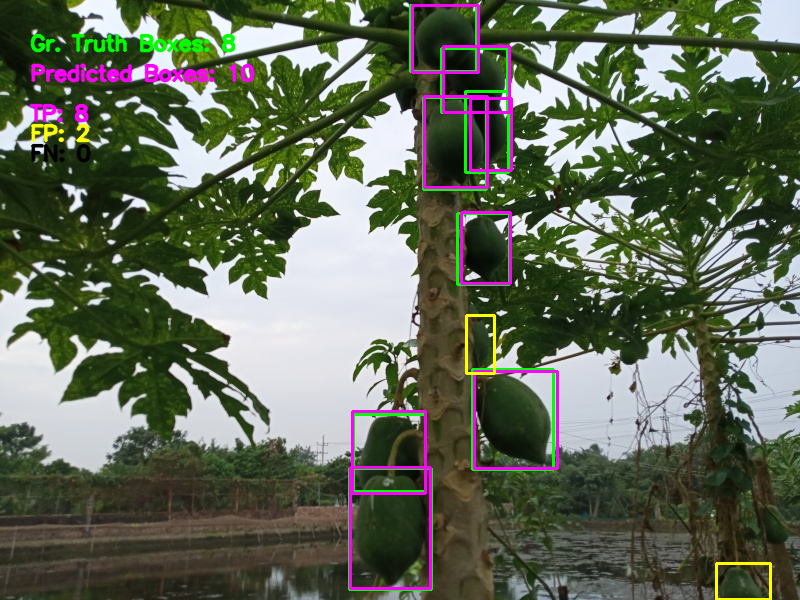

In [18]:
import cv2
img_name = '50.jpg'
ground_truth_boxes = ground_truth_dict[img_name.split('.')[0]]
print(ground_truth_boxes)
# predicted_boxes = predict_dict[img_name]
predicted_boxes = predict_dict[img_name.split('.')[0]]
(ground_truth_no,predicted_no,tp_boxes,fp_boxes,fn_boxes,TP,FP,FN) = calculate_tf_fp_fn(ground_truth_boxes,predicted_boxes)
img_path = '/content/drive/MyDrive/MScThesis/YOLOv8/Old_415_papaya_data/Org_Gaussian___Org/data/test/images/'+img_name
draw_img_tp_fp_fn(img_path, ground_truth_no, predicted_no, tp_boxes, fp_boxes, fn_boxes, TP,FP,FN)
 #Display the predicted boxes
# print('TP:')
# for box in tp_boxes:
#   print(box)
# print("\nF_P:")
# for box in fp_boxes:
#   print(box)
# print("\nF_N:")
# for box in fn_boxes:
#   print(box)